In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import gensim

from transformers import BertTokenizer

import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Data

## First Dataset

In [2]:
df1 = pd.read_csv('data\Emotion-Dataset-from-Indonesian-Public-Opinion\Emotion Dataset from Indonesian Public Opinion/AngerData.csv', sep='\t')
df2 = pd.read_csv('data\Emotion-Dataset-from-Indonesian-Public-Opinion\Emotion Dataset from Indonesian Public Opinion/FearData.csv', sep='\t')
df3 = pd.read_csv('data\Emotion-Dataset-from-Indonesian-Public-Opinion\Emotion Dataset from Indonesian Public Opinion/JoyData.csv', sep='\t')
df4 = pd.read_csv('data\Emotion-Dataset-from-Indonesian-Public-Opinion\Emotion Dataset from Indonesian Public Opinion/LoveData.csv', sep='\t')
df5 = pd.read_csv('data\Emotion-Dataset-from-Indonesian-Public-Opinion\Emotion Dataset from Indonesian Public Opinion/SadData.csv', sep='\t')

# Combine the DataFrames along the rows
dataset1 = pd.concat([df1, df2, df3, df4, df5], axis=0)
dataset1.rename(columns={'Tweet': 'tweet', 'Label':'label'}, inplace=True)

In [3]:
dataset1.sample(10)

tweet  label
675  pram said ini lgu buat kalian, yang punya ruma...  Anger
0    suka banget kata2, "kebenaran hanya menurut se...   Love
69                                jpn, sgp takut gilaa   Fear
750  kenapa aku kalo reflek tuh suka malu maluin di...   Fear
259            mun ujar jhon tralala "semangat cantik"    Joy
724  semua harus di bayar dengan balas dendam -sasu...  Anger
252  bandung aku baca sekali, ampe sekarang belom b...   Love
604  ngga nder, kyk nya gara2 quarantine deh. soaln...    Sad
535  mukanya tegang amat om puput kayak menanggung ...   Fear
860                                   gak enak rasanya    Sad

In [4]:
dataset1.shape

(5079, 2)

In [5]:
dataset1.groupby('label').count()

tweet
label       
Anger   1130
Fear     911
Joy     1275
Love     760
Sad     1003

In [6]:
dataset1['label'].replace('Anger', 'anger', inplace=True)
dataset1['label'].replace('Fear', 'fear', inplace=True)
dataset1['label'].replace('Joy', 'happy', inplace=True)
dataset1['label'].replace('Love', 'love', inplace=True)
dataset1['label'].replace('Sad', 'sad', inplace=True)
dataset1.groupby('label').count()

tweet
label       
anger   1130
fear     911
happy   1275
love     760
sad     1003

In [7]:
dataset1.drop_duplicates(inplace=True)
dataset1.duplicated().sum()

0

In [8]:
# # Split the data into train (60%), test(20%), and validation(20%) sets
# dataset1_train, dataset1_test = train_test_split(dataset1, test_size=0.2, random_state=42)
# dataset1_train, dataset1_val= train_test_split(dataset1_train, test_size=0.25, random_state=42)

## Second dataset

In [9]:
dataset2 = pd.read_csv('data/Indonesian-Twitter-Emotion-Dataset/Twitter_Emotion_Dataset.csv')
dataset2 = dataset2.reindex(columns=['tweet', 'label'])
dataset2.head()

tweet  label
0  Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...  anger
1  Sesama cewe lho (kayaknya), harusnya bisa lebi...  anger
2  Kepingin gudeg mbarek Bu hj. Amad Foto dari go...  happy
3  Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...  anger
4  Sharing pengalaman aja, kemarin jam 18.00 bata...  happy

In [10]:
dataset2.groupby('label').count()

tweet
label         
anger     1101
fear       649
happy     1017
love       637
sadness    997

In [11]:
dataset2['label'].replace('sadness', 'sad', inplace=True)
dataset2.groupby('label').count()

tweet
label       
anger   1101
fear     649
happy   1017
love     637
sad      997

## Merged Dataset

In [12]:
test = pd.concat([dataset1, dataset2], axis=0)

In [13]:
test.iloc[1747]

tweet    lah kann pada salty ngapa dah ak baru twt kage...
label                                                 fear
Name: 627, dtype: object

In [14]:
df_merged = pd.concat([dataset1, dataset2], axis=0)
# df_concat = pd.concat([dataset1, dataset2], axis=0)
# df_merged = df_concat.copy()
# df_concat.head()

In [15]:
df_merged.shape

(9437, 2)

In [16]:
df_merged.groupby('label').count()

tweet
label       
anger   2224
fear    1555
happy   2275
love    1391
sad     1992

In [17]:
df_merged['label'] = df_merged['label'].replace('anger', 0)
df_merged['label'] = df_merged['label'].replace('sad', 1)
df_merged['label'] = df_merged['label'].replace('fear', 2)
df_merged['label'] = df_merged['label'].replace('happy', 3)
df_merged['label'] = df_merged['label'].replace('love', 4)

df_merged.label.value_counts()

3    2275
0    2224
1    1992
2    1555
4    1391
Name: label, dtype: int64

# Preprocessing

In [18]:
df_merged['tweet'] = df_merged['tweet'].map(lambda x: x.lower())
df_merged.head()

tweet  label
0                        pagi2 udah di buat emosi :)      0
1  kok stabilitas negara, memange 10 thn negara t...      0
2                       dah lah emosi mulu liat emyu      0
3  aib? bodoh benar! sebelum kata aib itu muncul,...      0
4                            dih lu yg nyebelin bego      0

In [19]:
df_merged['tweet'] = df_merged['tweet'].apply(lambda x: re.sub(r"#", "", x))

# Find rows that have hashtags in their text
rows_with_hashtags = df_merged['tweet'].str.contains(r'#')

print(rows_with_hashtags.sum())

0


In [20]:
df_merged.drop_duplicates(inplace=True)
df_merged.duplicated().sum()

0

In [21]:
stop_words = set(nltk.corpus.stopwords.words("indonesian"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [22]:
singkatan_dict = pd.read_csv('data\Indonesian-Twitter-Emotion-Dataset\kamus_singkatan.csv', header=None, sep=';')
display(singkatan_dict.head())
singkatan_dict = singkatan_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

0         1
0   aamiin     amin 
1     adek     adik 
2     adlh   adalah 
3      aer      air 
4  aiskrim  es krim

In [23]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return stemmer.stem(text)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_URLs(text):
    text = text.replace('[URL]','')
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

singkatan_dict_map = dict(zip(singkatan_dict['original'], singkatan_dict['replacement']))
def normalize_alay(text):
    return ' '.join([singkatan_dict_map[word] if word in singkatan_dict_map else word for word in text.split(' ')])

def remove_username(text):
    return text.replace('[USERNAME]', '')

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_username(text)
    text = remove_between_square_brackets(text)
    text = remove_URLs(text)
    text = remove_nonaplhanumeric(text)
    text = stemming(text)
    text = normalize_alay(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_merged['tweet']=df_merged['tweet'].apply(denoise_text)

c:\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [24]:
df_merged.to_csv('data/preprocessed_data/data_bahasa.csv')

In [25]:
df_temp = df_merged.copy()
y = df_temp.pop('label')
X = df_temp.copy()

In [26]:
# Split the data into train (60%), test(20%), and validation(20%) sets

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [27]:
display.max_seq_items  = 9999

In [28]:
X_train.head()

tweet
35                                             takut ya
45                                           anjg kaget
3308             tindak aparat paksa laku tendang bebas
1747  sumbang suara lagu hellomellopoppunk mas anang...
1065  korelasi puasa parkir kosong marenmaren bikin ...

# WordCloud

In [29]:
df_merged.label.unique()

array([0, 2, 3, 4, 1], dtype=int64)

(-0.5, 1599.5, 799.5, -0.5)

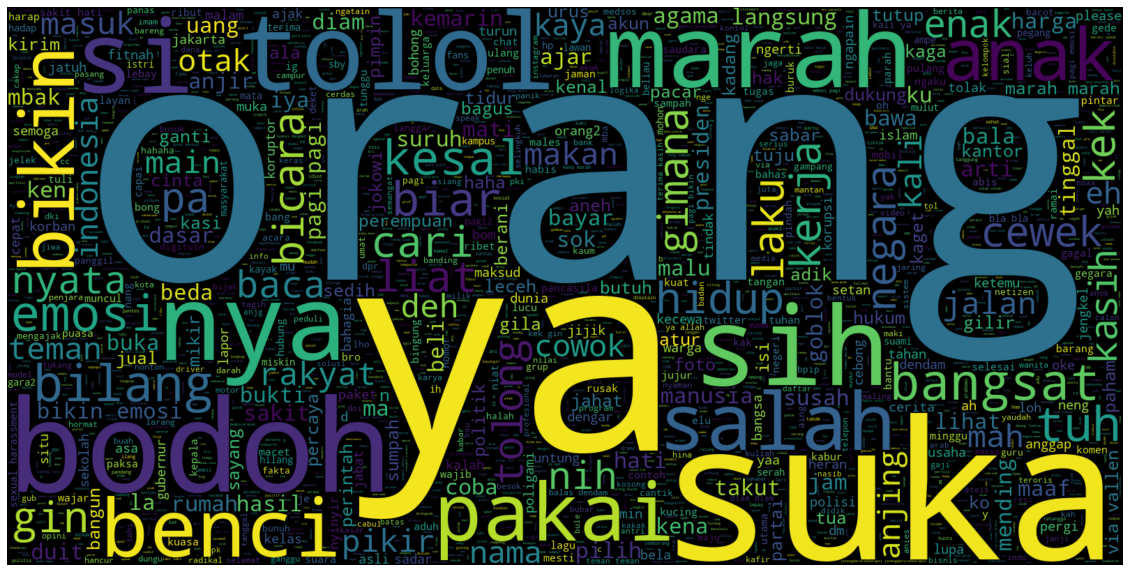

In [30]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_merged[df_merged.label == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

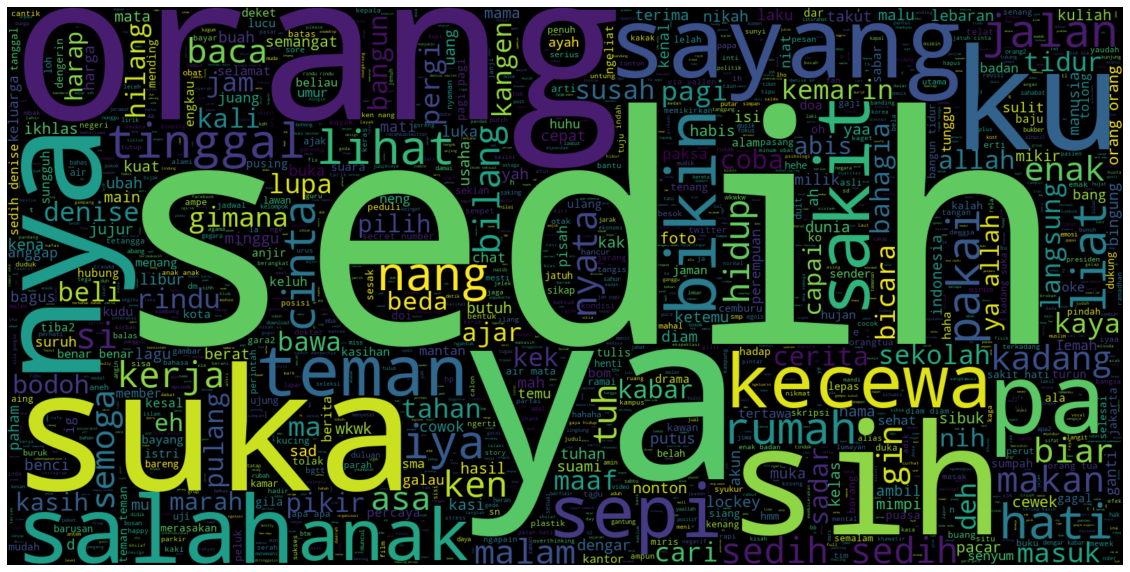

In [31]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_merged[df_merged.label == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

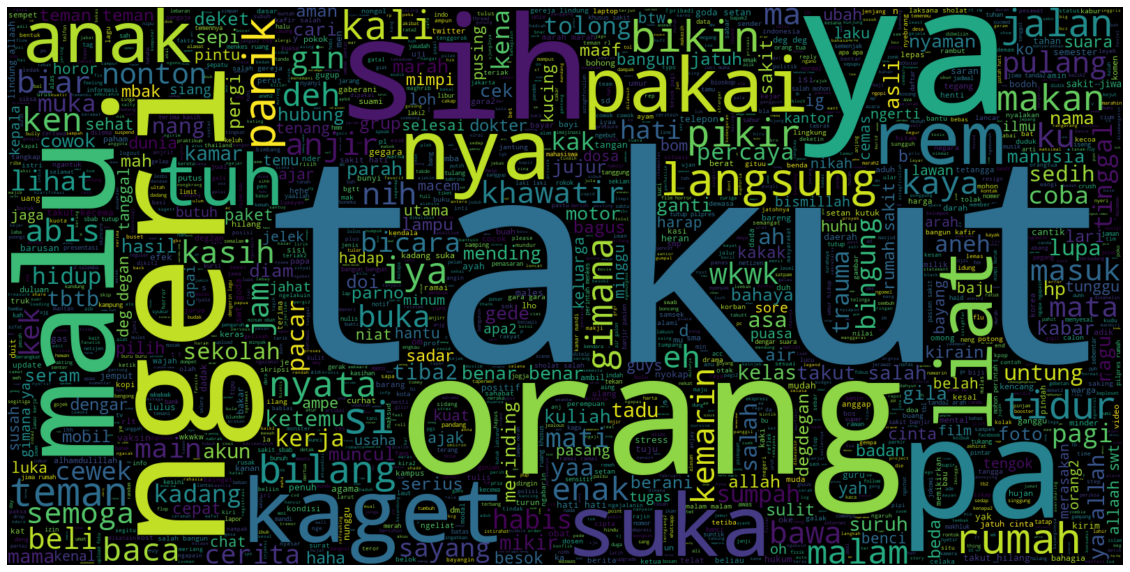

In [32]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_merged[df_merged.label == 2].tweet))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

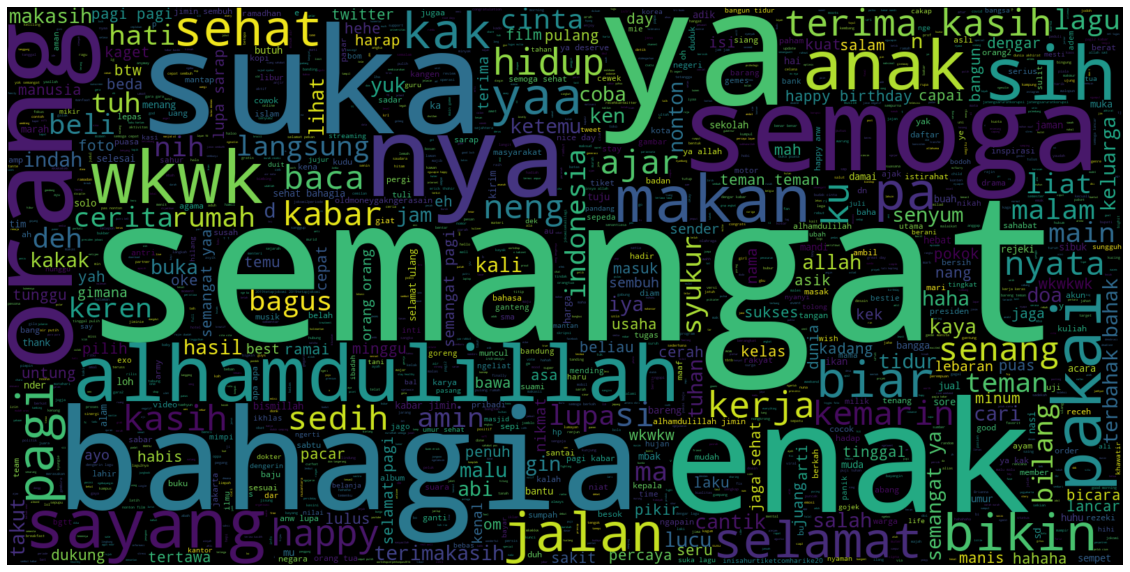

In [33]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_merged[df_merged.label == 3].tweet))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

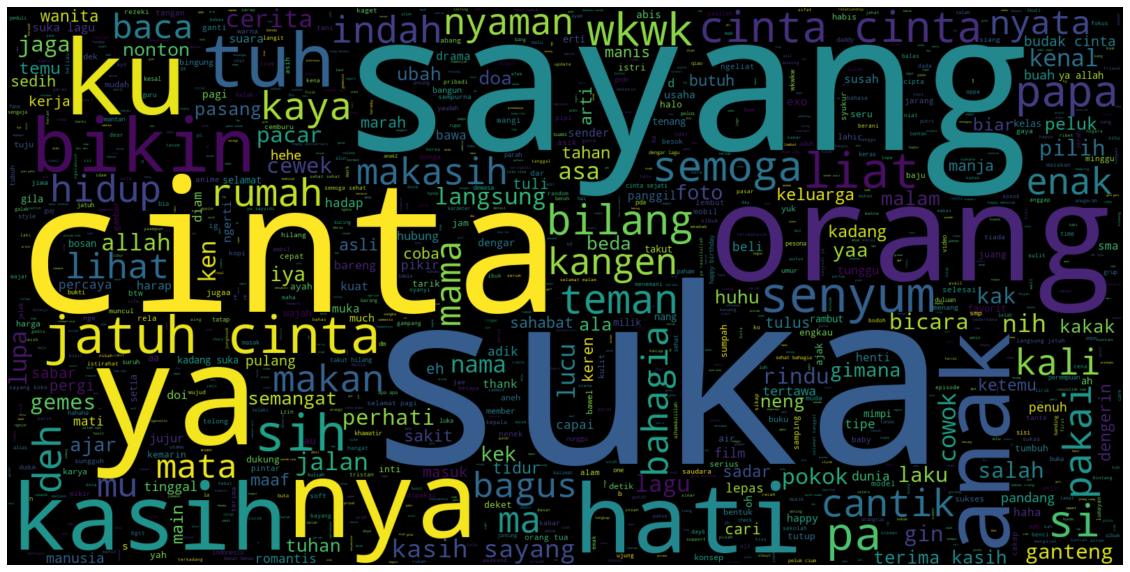

In [34]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_merged[df_merged.label == 4].tweet))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

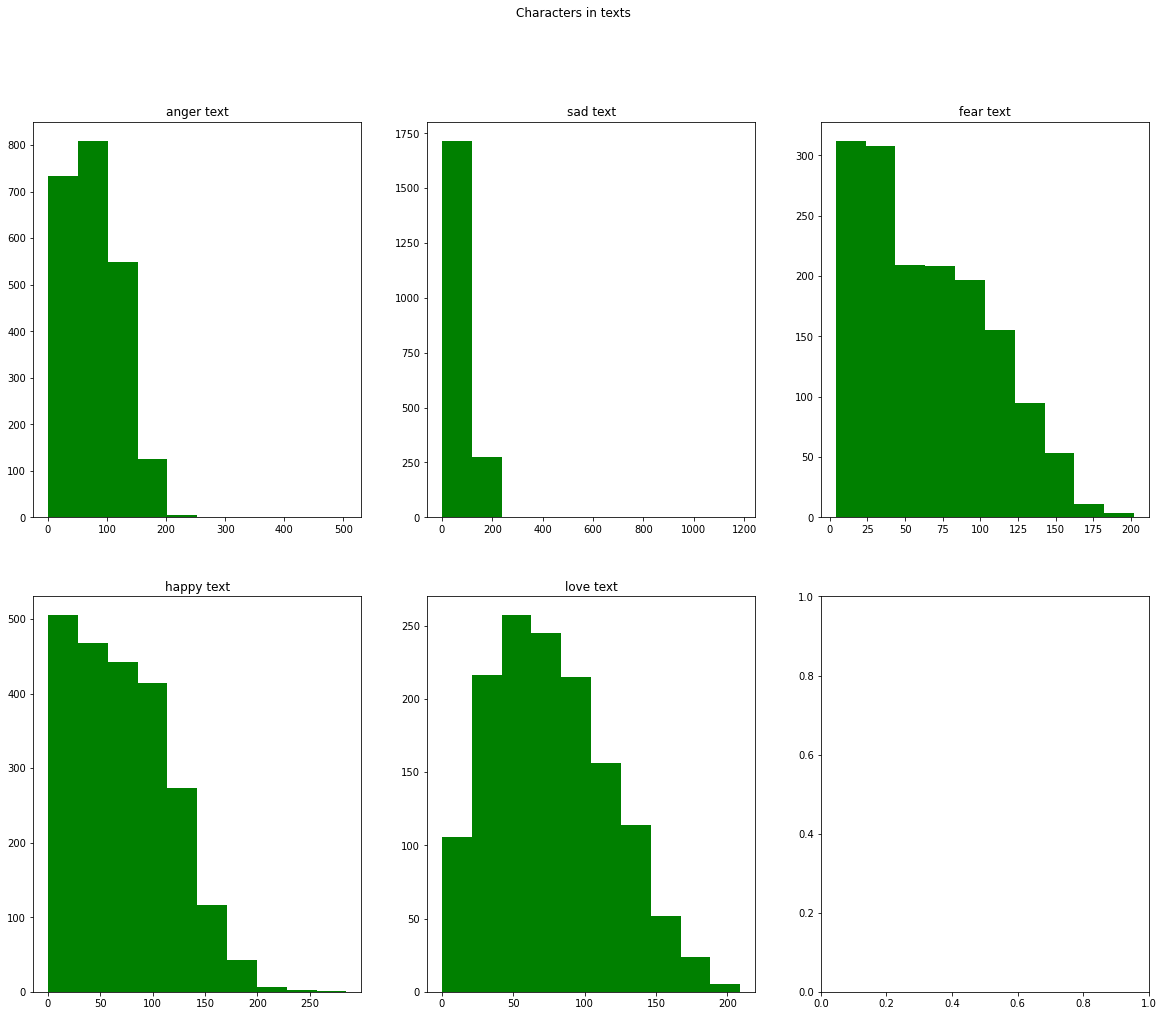

In [35]:
fig,axes =plt.subplots(nrows=2, ncols=3,figsize=(20,16))
text_len=df_merged[df_merged['label']==0]['tweet'].str.len()
axes[0,0].hist(text_len,color='green')
axes[0,0].set_title('anger text')
text_len=df_merged[df_merged['label']==1]['tweet'].str.len()
axes[0,1].hist(text_len,color='green')
axes[0,1].set_title('sad text')
text_len=df_merged[df_merged['label']==2]['tweet'].str.len()
axes[0,2].hist(text_len,color='green')
axes[0,2].set_title('fear text')
text_len=df_merged[df_merged['label']==3]['tweet'].str.len()
axes[1,0].hist(text_len,color='green')
axes[1,0].set_title('happy text')
text_len=df_merged[df_merged['label']==4]['tweet'].str.len()
axes[1,1].hist(text_len,color='green')
axes[1,1].set_title('love text')
fig.suptitle('Characters in texts')
plt.show()

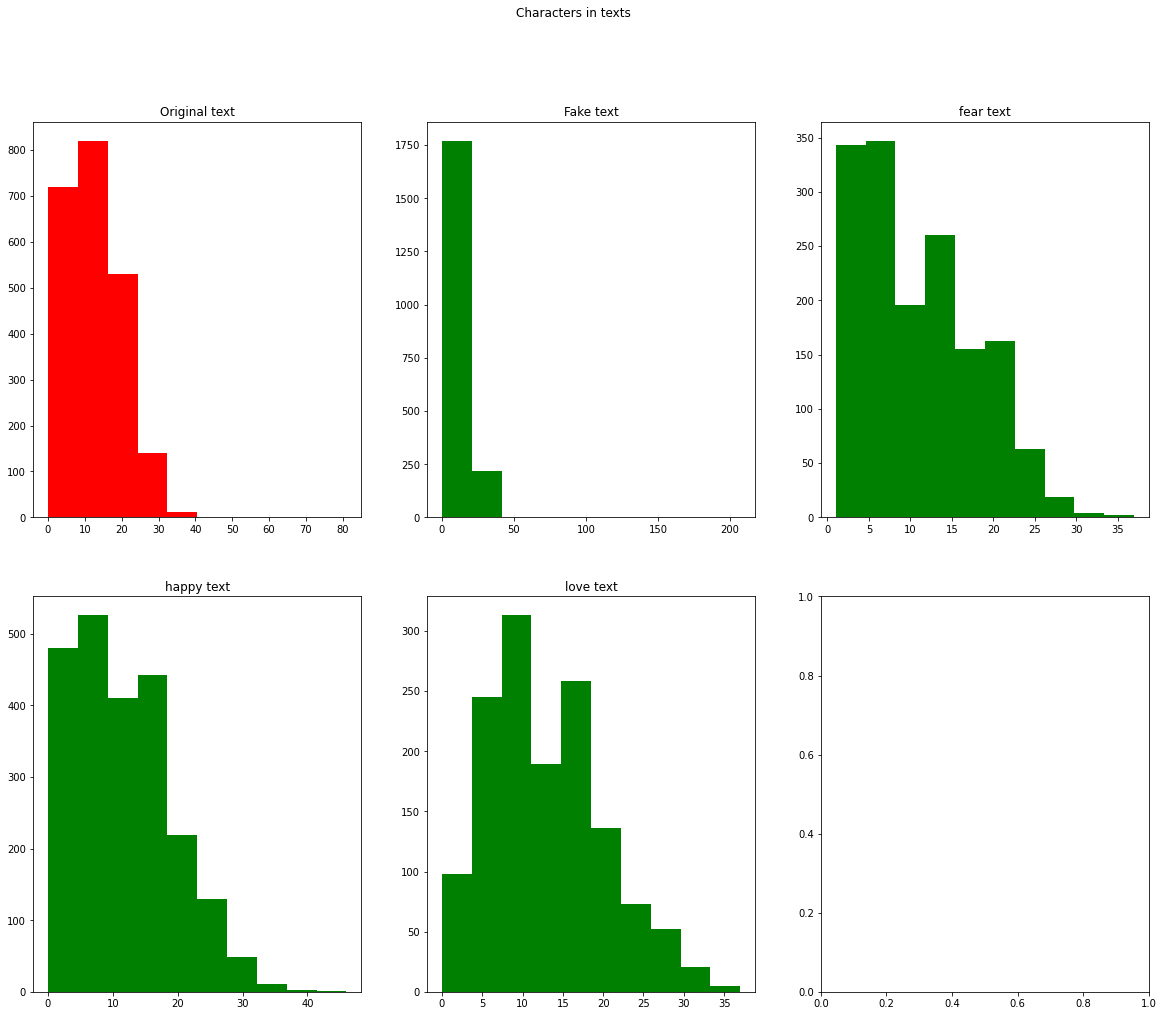

In [36]:
fig,axes =plt.subplots(nrows=2, ncols=3,figsize=(20,16))
text_len=df_merged[df_merged['label']==0]['tweet'].str.split().map(lambda x: len(x))
axes[0,0].hist(text_len,color='red')
axes[0,0].set_title('Original text')
text_len=df_merged[df_merged['label']==1]['tweet'].str.split().map(lambda x: len(x))
axes[0,1].hist(text_len,color='green')
axes[0,1].set_title('Fake text')
text_len=df_merged[df_merged['label']==2]['tweet'].str.split().map(lambda x: len(x))
axes[0,2].hist(text_len,color='green')
axes[0,2].set_title('fear text')
text_len=df_merged[df_merged['label']==3]['tweet'].str.split().map(lambda x: len(x))
axes[1,0].hist(text_len,color='green')
axes[1,0].set_title('happy text')
text_len=df_merged[df_merged['label']==4]['tweet'].str.split().map(lambda x: len(x))
axes[1,1].hist(text_len,color='green')
axes[1,1].set_title('love text')
fig.suptitle('Characters in texts')
plt.show()
fig.suptitle('Words in texts')
plt.show()

c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Muhammad Harun A\AppData\Local\Temp\ipykernel_7344\3966768869.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=axes[0,0],color='red')
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python3

Text(0.5, 0.98, 'Average word length in each text')

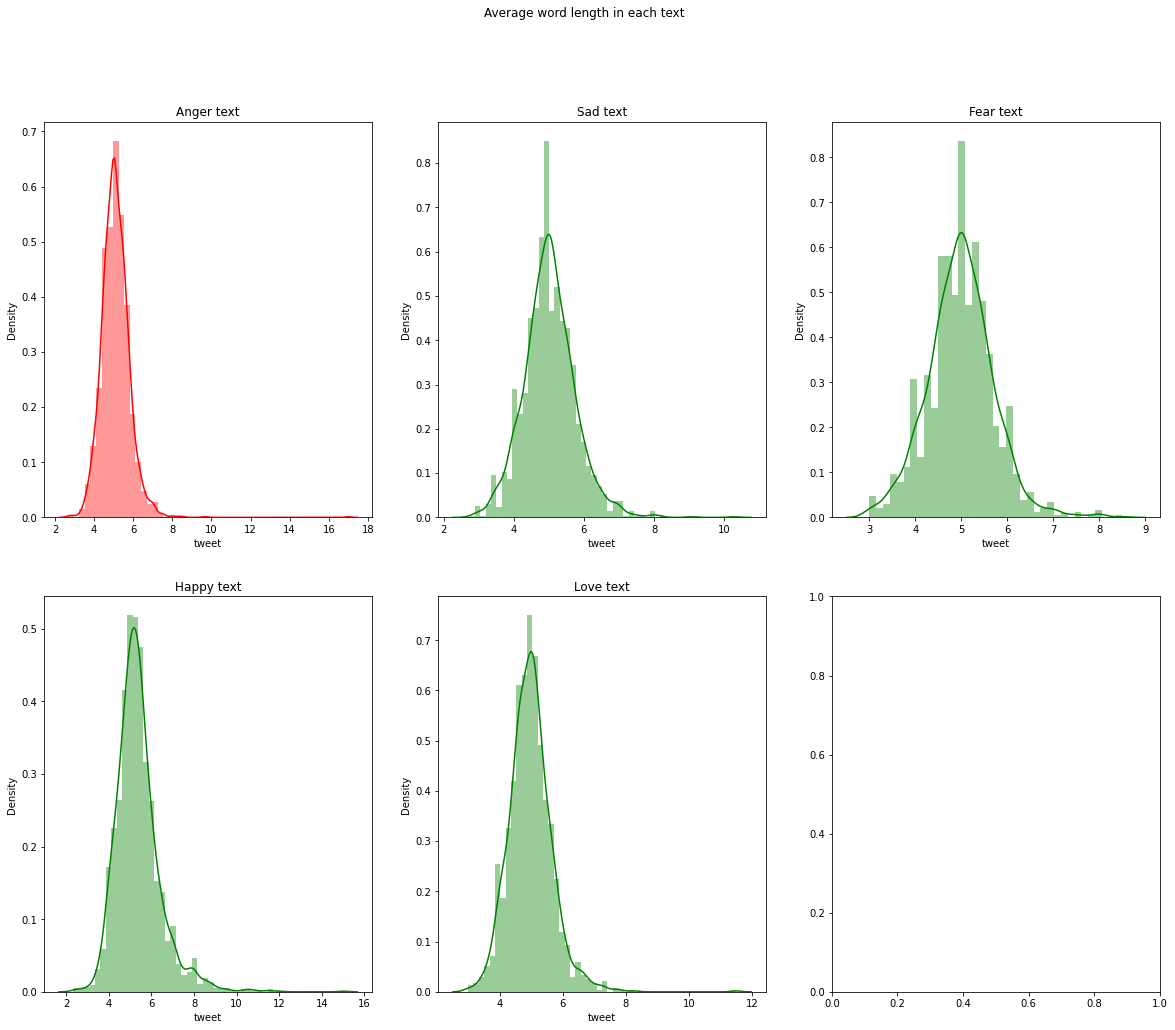

In [37]:
fig,axes =plt.subplots(nrows=2, ncols=3,figsize=(20,16))

word=df_merged[df_merged['label']==0]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=axes[0,0],color='red')
axes[0,0].set_title('Anger text')

word=df_merged[df_merged['label']==1]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=axes[0,1],color='green')
axes[0,1].set_title('Sad text')

word=df_merged[df_merged['label']==2]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=axes[0,2],color='green')
axes[0,2].set_title('Fear text')

word=df_merged[df_merged['label']==3]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=axes[1,0],color='green')
axes[1,0].set_title('Happy text')

word=df_merged[df_merged['label']==4]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=axes[1,1],color='green')
axes[1,1].set_title('Love text')

fig.suptitle('Average word length in each text')

In [38]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_merged.tweet)
corpus[:5]

['pagi2', 'emosi', 'stabilitas', 'negara', 'memange']

In [39]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'suka': 1611,
 'ya': 1556,
 'orang': 1442,
 'takut': 985,
 'sedih': 867,
 'cinta': 815,
 'sayang': 765,
 'nya': 659,
 'sih': 628,
 'semangat': 605}

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot: >

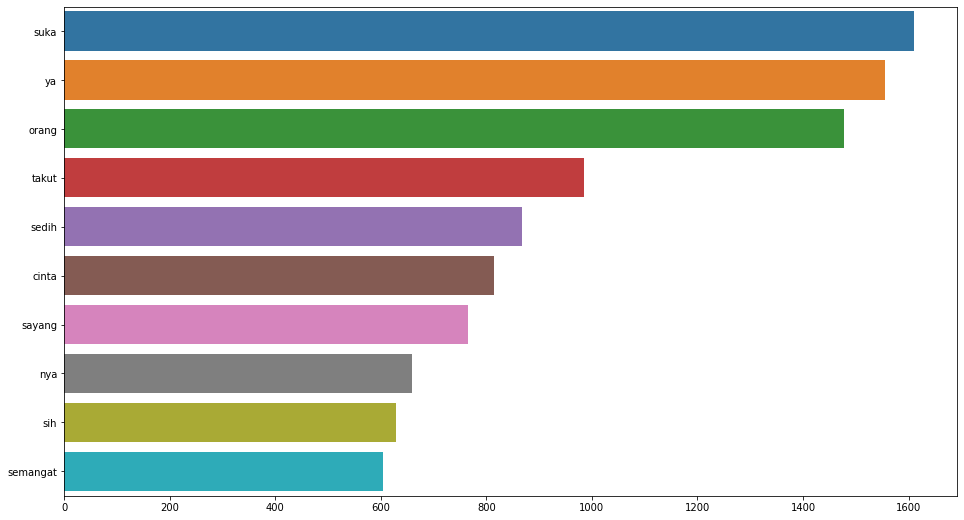

In [41]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df_merged.tweet,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<AxesSubplot: >

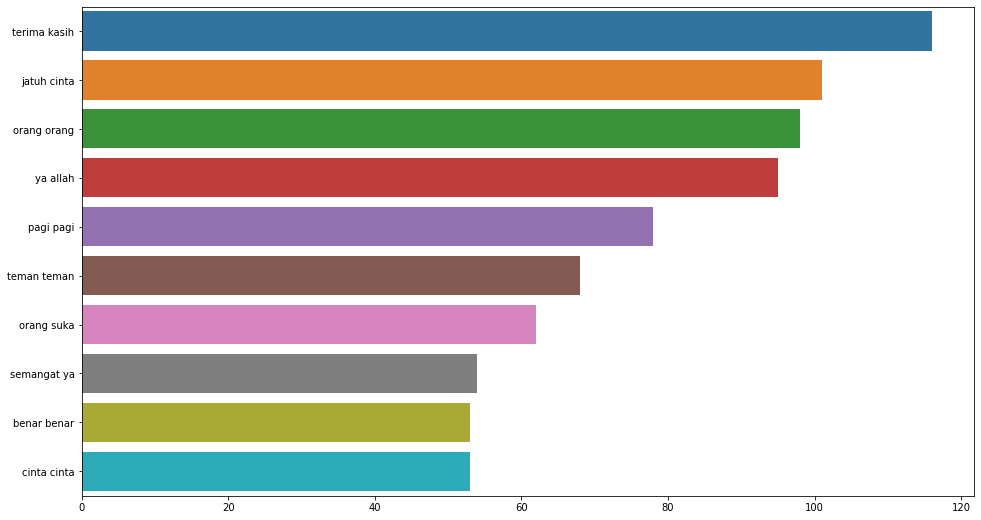

In [42]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df_merged.tweet,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<AxesSubplot: >

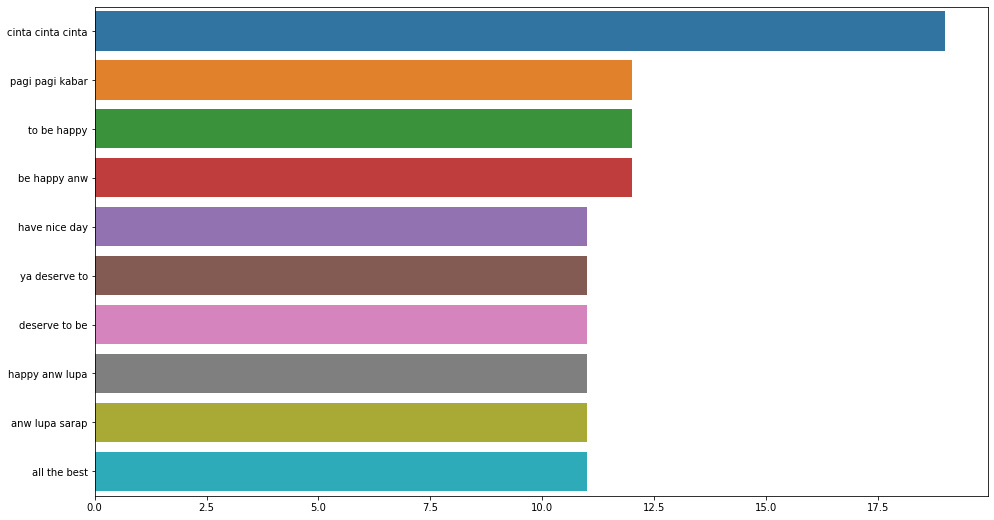

In [43]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df_merged.tweet,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

# W2V

In [44]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format('pretrained-embedding\indo\Word2Vec_400dim.txt', binary=False)

In [45]:
embeddings.vectors.shape

(129390, 400)

In [46]:
embeddings.get_vector('cinta')

array([-1.128944, -1.316949, -0.178413, -0.559552,  0.262635, -0.572677,
       -0.50944 , -0.228689, -0.581003, -1.064476,  1.253516, -0.263669,
       -1.70574 , -1.488693, -1.382221,  0.90137 , -0.924331,  0.403605,
       -1.172308, -0.628824,  1.797639, -0.249797, -1.024475,  1.565237,
        1.691971, -1.928691, -0.328867,  2.052958, -0.652756,  0.352125,
        1.017996, -0.959585, -2.383332,  3.075314,  1.281128, -1.949379,
       -2.773428,  0.815917,  0.491125, -1.343865,  2.007835, -0.680274,
        0.59642 ,  0.644186, -1.391925,  1.394655, -0.188582, -0.897676,
       -1.492438,  1.706866, -0.061925,  0.136202, -2.370367,  1.246064,
        0.509649, -0.46838 , -1.382894,  1.085023, -1.97225 , -0.317493,
        1.81405 , -1.203063,  0.585479,  0.634948,  0.466437,  0.734078,
        1.364624, -0.008714,  0.081562,  0.960741,  0.630246, -1.668633,
        0.756235, -1.447532,  0.258852, -1.537387,  1.495708, -1.761964,
        0.503651,  0.440326, -1.215836, -2.783167, 

In [47]:
embeddings.similar_by_word('bangsat')

[('najis', 0.6933817267417908),
 ('goblok', 0.6830256581306458),
 ('bangke', 0.6653270721435547),
 ('bacot', 0.63214510679245),
 ('tai', 0.6216129660606384),
 ('kampret', 0.6204587817192078),
 ('bgst', 0.6082442998886108),
 ('belagu', 0.6080747842788696),
 ('cuih', 0.6079771518707275),
 ('norak', 0.6077802181243896)]

In [48]:
embeddings.similar_by_word('sedih')

[('nangis', 0.5727053284645081),
 ('ketawa', 0.5019741654396057),
 ('kesal', 0.48555630445480347),
 ('kesepian', 0.48481470346450806),
 ('kecewa', 0.47758689522743225),
 ('tawa', 0.4769587814807892),
 ('kesel', 0.4720442593097687),
 ('tertawa', 0.4656045436859131),
 ('terharu', 0.45204979181289673),
 ('gelisah', 0.4492208957672119)]

# Test Modeling

## Convert X_test y_test

In [49]:
max_features = 10000
maxlen = 20

In [50]:
X_train.tweet

35                                               takut ya
45                                             anjg kaget
3308               tindak aparat paksa laku tendang bebas
1747    sumbang suara lagu hellomellopoppunk mas anang...
1065    korelasi puasa parkir kosong marenmaren bikin ...
                              ...                        
2640    bilang ngeyel isi ngejebak beliin ngomel jalan...
3038                         thenkyu cepat sembuh kena db
454     panik tetiba mata bengkak belah nyata alergi i...
1217                                     gila jatuh cinta
1990    survey cewek bilang cowok omonganya pegang nya...
Name: tweet, Length: 5655, dtype: object

In [51]:
## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
X_train_tokenized = [tokenizer.encode(sent, add_special_tokens=True, max_length= maxlen, pad_to_max_length=True,truncation=True) for sent in X_train.tweet.values]
X_val_tokenized = [tokenizer.encode(sent, add_special_tokens=True, max_length= maxlen, pad_to_max_length=True,truncation=True) for sent in X_val.tweet.values]
X_test_tokenized = [tokenizer.encode(sent, add_special_tokens=True, max_length= maxlen, pad_to_max_length=True,truncation=True) for sent in X_test.tweet.values]

C:\Users\Muhammad Harun A\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Muhammad Harun A\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Muhammad Harun A\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_bas

In [52]:
print("Actual sentence before tokenization: ",X_train.tweet.values[:5])
print("Encoded Input from dataset: ",X_train_tokenized[:5])

Actual sentence before tokenization:  ['takut ya' 'anjg kaget' 'tindak aparat paksa laku tendang bebas'
 'sumbang suara lagu hellomellopoppunk mas anang sih yes hellomellopoppunk hellomello poppunk subang recording masterplan recording chamber'
 'korelasi puasa parkir kosong marenmaren bikin emoshi tyap gegara sulit parkir gilir bawa mobil kosyoong melomponggggg lyfe']
Encoded Input from dataset:  [[101, 27006, 4904, 8038, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2019, 3501, 2290, 10556, 18150, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 9543, 23597, 9706, 25879, 22190, 3736, 2474, 5283, 7166, 5654, 2022, 22083, 102, 0, 0, 0, 0, 0, 0], [101, 7680, 25153, 10514, 5400, 2474, 12193, 7592, 10199, 4135, 16340, 14289, 8950, 16137, 9617, 3070, 9033, 2232, 2748, 102], [101, 12849, 16570, 21369, 16405, 16782, 2380, 4313, 12849, 3385, 2290, 11941, 2078, 24376, 2078, 12170, 4939, 7861, 24303, 102]]


In [53]:
batch_size = 256
epochs = 25
embed_size = 400

In [54]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [55]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(input_dim=embeddings.vectors.shape[0], output_dim=embeddings.vectors.shape[1], weights=[embeddings.vectors], trainable=False)),#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 400)         51756000  
                                                                 
 lstm (LSTM)                 (None, None, 128)         270848    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 52,078,501
Trainable params: 322,501
Non-trainable params: 51,756,000
_________________________________________________________________


In [57]:
type(X_train_tokenized)

list

In [58]:
X_train_input = tf.convert_to_tensor(X_train_tokenized)
X_val_input = tf.convert_to_tensor(X_val_tokenized)

# y_train_input = tf.convert_to_tensor(y_train)
# y_val_input = tf.convert_to_tensor(y_val)

y_train_input = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val_input = tf.keras.utils.to_categorical(y_val, num_classes=5)
print(y_train_input)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


In [59]:
history = model.fit(X_train_input, 
                    y_train, 
                    batch_size = batch_size, 
                    validation_data = (X_val_input, y_val), 
                    epochs = epochs, 
                    callbacks = [learning_rate_reduction]
                    )

Epoch 1/25
23/23 [==============================] - 14s 344ms/step - loss: 1.6006 - accuracy: 0.2440 - val_loss: 1.5717 - val_accuracy: 0.2822 - lr: 0.0100
Epoch 2/25
23/23 [==============================] - 9s 373ms/step - loss: 1.4917 - accuracy: 0.3103 - val_loss: 1.4422 - val_accuracy: 0.3586 - lr: 0.0100
Epoch 3/25
23/23 [==============================] - 7s 287ms/step - loss: 1.3684 - accuracy: 0.3809 - val_loss: 1.3557 - val_accuracy: 0.4101 - lr: 0.0100
Epoch 4/25
23/23 [==============================] - 7s 304ms/step - loss: 1.2615 - accuracy: 0.4707 - val_loss: 1.2571 - val_accuracy: 0.4621 - lr: 0.0100
Epoch 5/25
23/23 [==============================] - 7s 311ms/step - loss: 1.1700 - accuracy: 0.5296 - val_loss: 1.2007 - val_accuracy: 0.5401 - lr: 0.0100
Epoch 6/25
23/23 [==============================] - 6s 269ms/step - loss: 1.0555 - accuracy: 0.5949 - val_loss: 1.1648 - val_accuracy: 0.5538 - lr: 0.0100
Epoch 7/25
23/23 [==============================] - 6s 272ms/step - l